In [29]:
import datetime
import spiceypy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# load the kernels
spiceypy.furnsh("kernels/lsk/naif0012.tls")
spiceypy.furnsh("kernels/spk/de432s.bsp")

# get the current datetime and convert it to ET
date_time = datetime.datetime.now().strftime("%Y-%m-%dT%H:%M:%S")
date_time_et = spiceypy.utc2et(date_time)

In [30]:
solar_system_df = pd.DataFrame()

solar_system_df.loc[:, "ET"] = [date_time_et]
solar_system_df.loc[:, "UTC"] = [date_time]

solarsystem_dictionary = {"sun": 10, "venus":299, "moon":301, "mars": 4, "jupiter": 5, "saturn": 6, "uranus": 7, "neptune": 8, "pluto": 9}
# color array for the planets
body_color_array = ["#f15c23", "#FDFD96", "#6f6b68", "#BF6C5A", "#BFAE99", "#dab778", "#94babe", "#789ebf",  "#eae2d3"]


for planet in solarsystem_dictionary:
    # calculate the ecliptic coordinates of the planets as seen from earth
    solar_system_df.loc[:, f"{planet}_to_earth_equatorial"] = solar_system_df["ET"].apply(lambda x: spiceypy.spkezp(targ=solarsystem_dictionary[planet], et=x, ref="J2000", abcorr="LT+S", obs=399)[0])
    
    # changes the vertices to longitude coordinates
    solar_system_df.loc[:, f"{planet}_long_radiants_equatorial"] = solar_system_df[f"{planet}_to_earth_equatorial"].apply(lambda x: spiceypy.recrad(x)[1])

    # changes the vertices to latitude coordinates
    solar_system_df.loc[:, f"{planet}_lat_radiants_equatorial"] = solar_system_df[f"{planet}_to_earth_equatorial"].apply(lambda x: spiceypy.recrad(x)[2])

    # invert the longitude coordinates to get the radiants for plotting
    solar_system_df.loc[:,f"{planet}_long_radiants4plot_equatorial"] = solar_system_df[f"{planet}_long_radiants_equatorial"].apply(lambda x: -1.0*((x%np.pi) - np.pi) if x >np.pi else -1.0*x)

In [31]:
ecliptic_plane = pd.DataFrame()

ecliptic_plane.loc[:, "ECLIPJ2000_long_radiant"] = np.linspace(0, 2*np.pi, 100)
ecliptic_plane.loc[:, "ECLIPJ2000_lat_radiant"] = np.pi / 2.0
ecliptic_plane.loc[:, "ECLIPJ2000_direction"] = ecliptic_plane.apply(lambda x: spiceypy.sphrec(r=1, colat=x["ECLIPJ2000_lat_radiant"], lon=x["ECLIPJ2000_long_radiant"]), axis=1)

# transform the ecliptic coordinates to equatorial ones
ecliptic2equatorial = spiceypy.pxform(fromstr="ECLIPJ2000", tostr="J2000", et=date_time_et)

# execute the transformation on the ecliptic coordinates
ecliptic_plane.loc[:, "ECLIPJ2000_to_J2000"] = ecliptic_plane["ECLIPJ2000_direction"].apply(lambda x: ecliptic2equatorial.dot(x))

# transform the longitude coordinates
ecliptic_plane.loc[:, "J2000_long_radiant"]  = ecliptic_plane["ECLIPJ2000_to_J2000"].apply(lambda x: spiceypy.recrad(x)[1])

# transform the latitiude coordinates
ecliptic_plane.loc[:, "J2000_lat_radiant"]  = ecliptic_plane["ECLIPJ2000_to_J2000"].apply(lambda x: spiceypy.recrad(x)[2])

# invert the longitude coordinates to get the radiants for plotting
ecliptic_plane.loc[:, "J2000_long_radiant4plot"] = ecliptic_plane["J2000_long_radiant"].apply(lambda x: -1.0*((x%np.pi) - np.pi) if x >np.pi else -1.0*x)

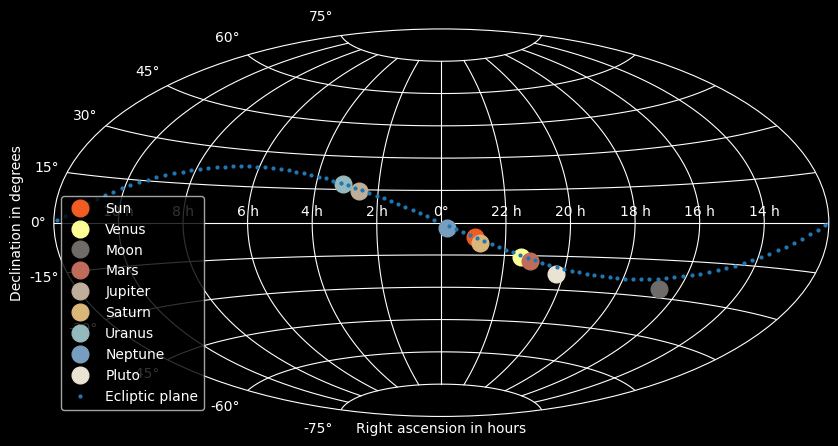

In [33]:
plt.style.use("dark_background")
plt.figure(figsize=(10, 10))

# the aitoff projection preserves longitude and latitude in its lines, so it is the best projection for this case
plt.subplot(projection="aitoff")

# make it pretty
plt.grid(True)
plt.xlabel("Right ascension in hours")
plt.ylabel("Declination in degrees")

# add our data
for planet, color in zip(solarsystem_dictionary, body_color_array):
    plt.plot(solar_system_df[f"{planet}_long_radiants4plot_equatorial"], solar_system_df[f"{planet}_lat_radiants_equatorial"], color=color, linestyle = "None", marker= "o", markersize=12, label=planet.capitalize())

plt.plot(ecliptic_plane["J2000_long_radiant4plot"], ecliptic_plane["J2000_lat_radiant"], color="tab:blue", linestyle = "None", marker= "o", markersize=2, label="Ecliptic plane")

plt.xticks(ticks=np.radians(np.arange(-150,180,30)), labels=["10 h", "8 h", "6 h", "4 h", "2 h", "0°", "22 h", "20 h", "18 h", "16 h", "14 h"])

plt.legend()